<a href="https://colab.research.google.com/github/Anyaoma/modernpython/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

According to D Ruppert & D Matteson, (2015), a stochastic process is a sequence of random variables, which is viewed as the population from which a time series is sampled from.

A time series is an equally spaced data sequence of observations ordered by time. e.g stock price, CPI data etc.

Time series model is a mathematical representation of how values in the time series are related to each other. It assumes weak stationarity, that is, the distributional properties of the time series (mean, variance and autocovariance) are time invariant.

The assumption of stationarity in a time series model is made to ensure parsimony, otherwise known as simple models. This sort of models are easier to interprete and less prone to overfitting. Also, stationarity in a time series indicates that the series can be modeled with relatively few parameters.



# ARE FINANCIAL STOCK SERIES STATIONARY?

While financial assets are not stationary in themselves (due to trends and seasonal variations), the changes in them - even if they differ from the previous period - exhibit same mean, standard deviation and other statistical properties from one period to the next(perhaps after applying a log transformation) (D Ruppert & D Matteson, 2015). This property of financial time series enables the applicability of time series model.


# NETFLIX TIME SERIES MODELING
The purpose of this excercise is to model NETFLIX stock price and forecast it.

In [52]:
pip install arch

In [53]:
!pip install pmdarima

In [54]:
#IMPORT RELEVANT LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch.unitroot import ADF, KPSS
import datetime
import pandas_datareader.data as web
import yfinance as yfin

yfin.pdr_override()

plt.rcParams["figure.figsize"] = (12, 9)

In [55]:
#START AND END DATE OF REQUIRED DATA
end_date = datetime.date(2024,1,31)
start_date = datetime.date(2014,1,10)

In [56]:
#DOWNLOAD NETFLIX DATASETS
data = pd.DataFrame(web.DataReader('NFLX', start_date, end_date, interval= '1d')['Adj Close'])
data = data.rename(columns={"Adj Close": "NETFLIX"})
data.head()

[*********************100%%**********************]  1 of 1 completed


,NETFLIX
Date,
2014-01-10,47.448570
2014-01-13,48.115715
2014-01-14,48.279999
2014-01-15,47.197144
2014-01-16,47.382858


#### Figure 1: Plots of NETFLIX stock price

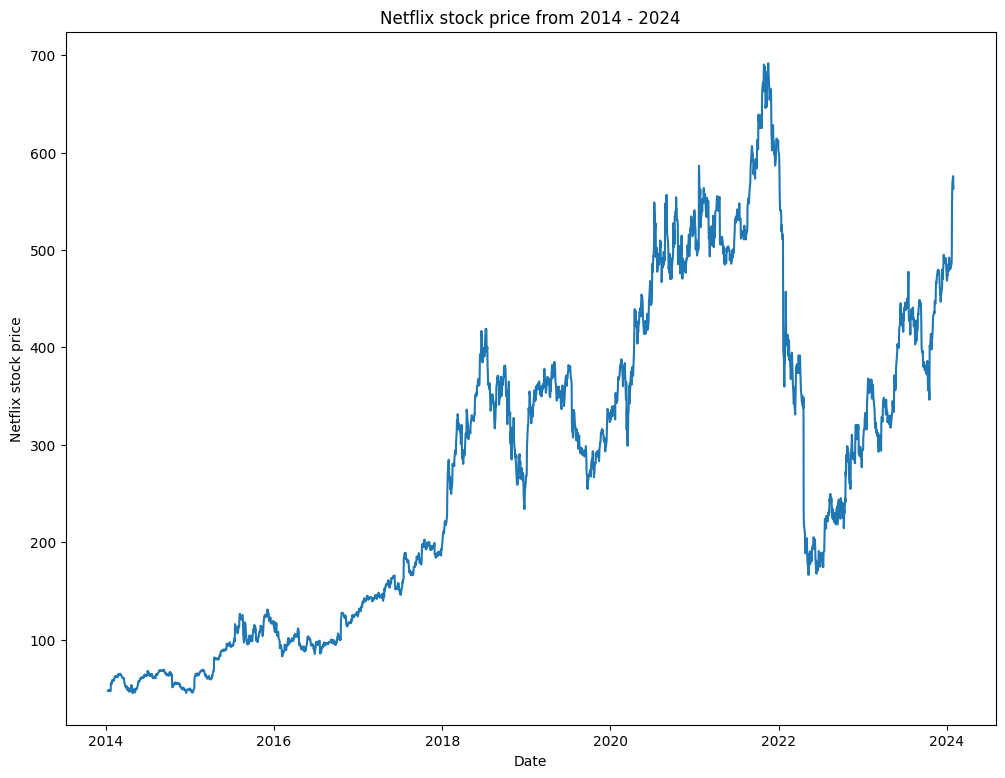

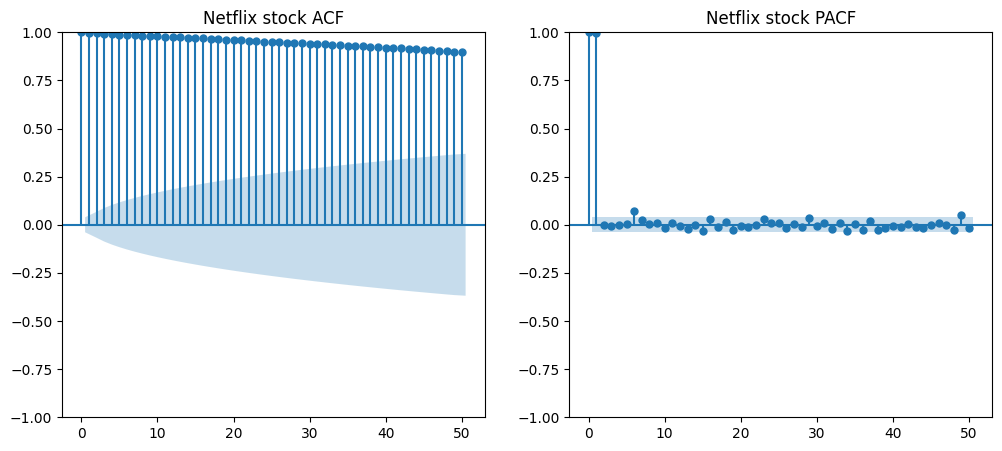

In [57]:
#Time series plot of NETFLIX stock price

plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Netflix stock price')
plt.title('Netflix stock price from 2014 - 2024')

# plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(data, title="Netflix stock ACF", lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(data, title="Netflix stock PACF", lags=50, ax=ax2)
plt.show()

The line plot of Netflix stock price indicates that the series has momentum - once the process starts moving upward or downward, it tends to continue in that direction. This indicates that the series is non stationary and might require double differencing.

Similarly, the ACF plots exhibits a slowly decaying autocorrelation. This implies that the series has systematic pattern and its statistical properties are changing over time.

We can perform a unit root test for a more nuanced examination of the underlying characteristics of a time series and helps determine whether it exhibits stationarity or non-stationarity

#### Figure 2: ADF unit root test

In [58]:
# UNADF test with drift and trend component
adf_trend = ADF(data, trend="ct", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", adf_trend.regression.summary())
print("\nTest statistics and critical values: \n", adf_trend)

Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.222
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.109
Time:                        14:48:03   Log-Likelihood:                -9032.0
No. Observations:                2529   AIC:                         1.807e+04
Df Residuals:                    2526   BIC:                         1.809e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1    

The P-value of the test statistic is greater than 0.05. Hence we accept the null hypothesis that NETFLIX stock price has a unit root. Additionally, the T-statistic (-2.096) of the ADF test is greater than the citical level at 5% significance level.

#### Figure 3: KPSS unit root test

In [59]:
# KPSS test of unit toot
print(KPSS(data, trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.836
P-value                         0.000
Lags                               27
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


Under the KPSS test, P-value is less than 0.05. We reject the null hypothesis of weak stationarity, thereby complementing the result of the ADF test.

#### Figure 4: Plots of Log difference of NETFLIX stock price

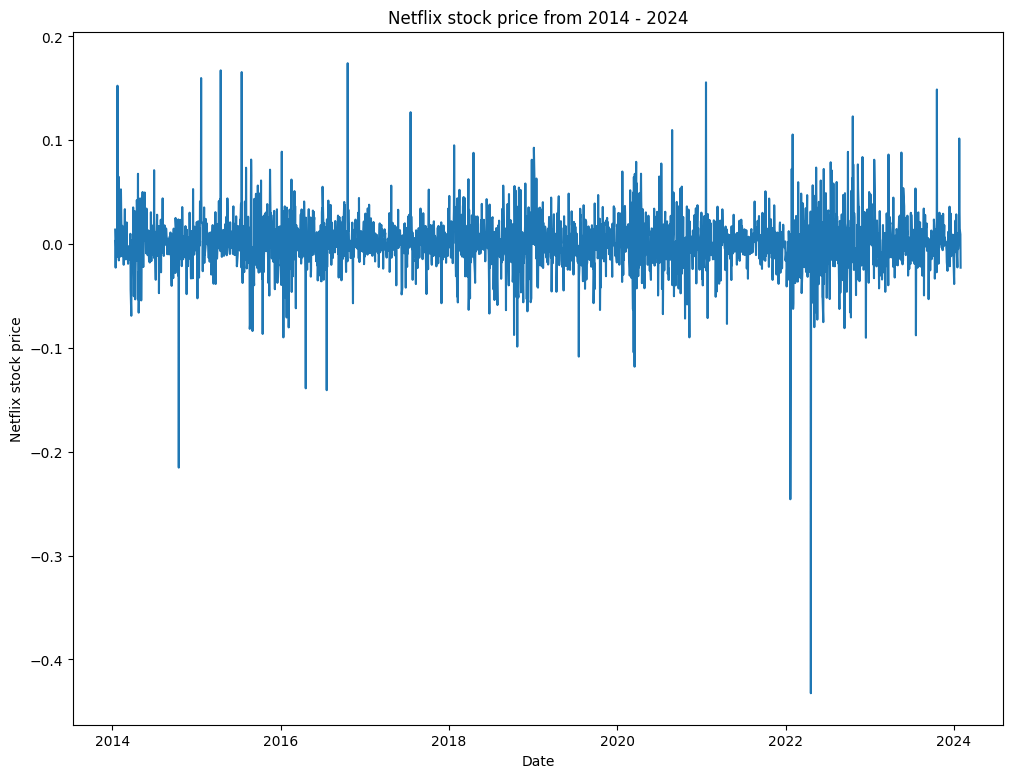

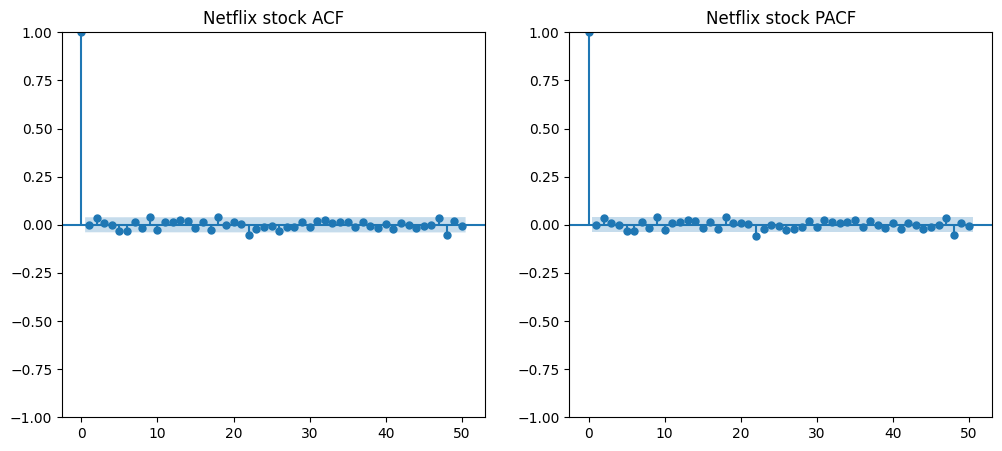

In [60]:
#Time series plot of log difference of NETFLIX stock price --> stock returns

plt.plot(np.log(data).diff().dropna())
plt.xlabel('Date')
plt.ylabel('Netflix stock price')
plt.title('Netflix stock price from 2014 - 2024')

# plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(np.log(data).diff().dropna(), title="Netflix stock ACF", lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(np.log(data).diff().dropna(), title="Netflix stock PACF", lags=50, ax=ax2)
plt.show()

The plot of the first difference of the stock price does exhibit stationarity. The return oscillates around zero showing signs of mean reversion. Although volatility  clustering is also evident, it can be modeled.

On the ACF plot, there is a rapid decay of autocorrelation, suggesting that the autocorrelation diminishes quickly and that the series lack any sytematic patterns (absence of trends, and seasonality).

However, the series indicates presence of serial correlations in some lags, although very minimal and barely significant. There are time series models that can capture correlation in the time series. The simplest correlated stationary processes are autoregressive processes, followed by Moving Average processes.

For next step, we can perform unit root testing on the log difference series

# UNIT ROOT TEST

#### Figure 5: ADF test of log differenced data

In [61]:
# ADF test with drift and trend component
adf_trend_1 = ADF(np.log(data).diff().dropna(), trend="ct", method="bic")
print("Augmented Dickey-Fuller Unit Root Test\n", adf_trend_1.regression.summary())
print("\nTest statistics and critical values: \n", adf_trend_1)

Augmented Dickey-Fuller Unit Root Test
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:48:04   Log-Likelihood:                 5408.6
No. Observations:                2528   AIC:                        -1.081e+04
Df Residuals:                    2525   BIC:                        -1.079e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1    

#### Figure 6: KPSS test of log differenced data

In [62]:
# KPSS test of unit toot
print(KPSS(np.log(data).diff().dropna(), trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.048
P-value                         0.607
Lags                               27
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


The results of both the ADF and KPPS test indicates that the log difference of NETFLIX stock is stationary. The next step of analysis is to model the series using either AR process, MA process or a combination of both using ARMA or ARIMA models.

In figure 4, from observig the ACF and PACF plot, we can try  𝑝=1
  and/or  𝑞=1
  or any other combinations. Fortunately, the statistical software, can automatically test several models and report back the best model with the lowest AIC and BIC. The following report shows various ARIMA models and their corresponding AICs.

In [63]:
# Efficient ARIMA model Selection
mod_auto_sel = auto_arima(
    np.log(data).dropna(),  # stepwise=False,
    start_p=0,
    start_d=0,
    start_q=0,
    max_p=3,
    max_d=3,
    max_q=3,
    trace=True,
    with_intercept=False,
    return_valid_fits=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10816.724, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-10814.725, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10814.724, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10813.000, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10817.704, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10815.706, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10815.706, Time=1.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10813.861, Time=1.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.739 seconds


The model selection process indicates that ARIMA(0,1,0) models the data appropriately. This means that a differenced white noise model fits the data appropriately while have the most minimal AIC.

#### Figure 7: ARIMA model estimation for NETFLIX stock price

In [64]:
# ARIMA Model for NETFLIX stock price
mod_arima = SARIMAX(np.log(data), order=(0, 1, 0), trend="c").fit()  # This is the best model in Python implementation
print(mod_arima.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                NETFLIX   No. Observations:                 2530
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5410.852
Date:                Mon, 22 Apr 2024   AIC                         -10817.704
Time:                        14:48:09   BIC                         -10806.033
Sample:                             0   HQIC                        -10813.470
                               - 2530                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0010      0.001      1.672      0.095      -0.000       0.002
sigma2         0.0008   6.07e-06    133.645      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

The result of the model suggets very minimal serial correlation in the model

# MODEL DIAGNOSTICS

#### Figure 8: Model diagnostics

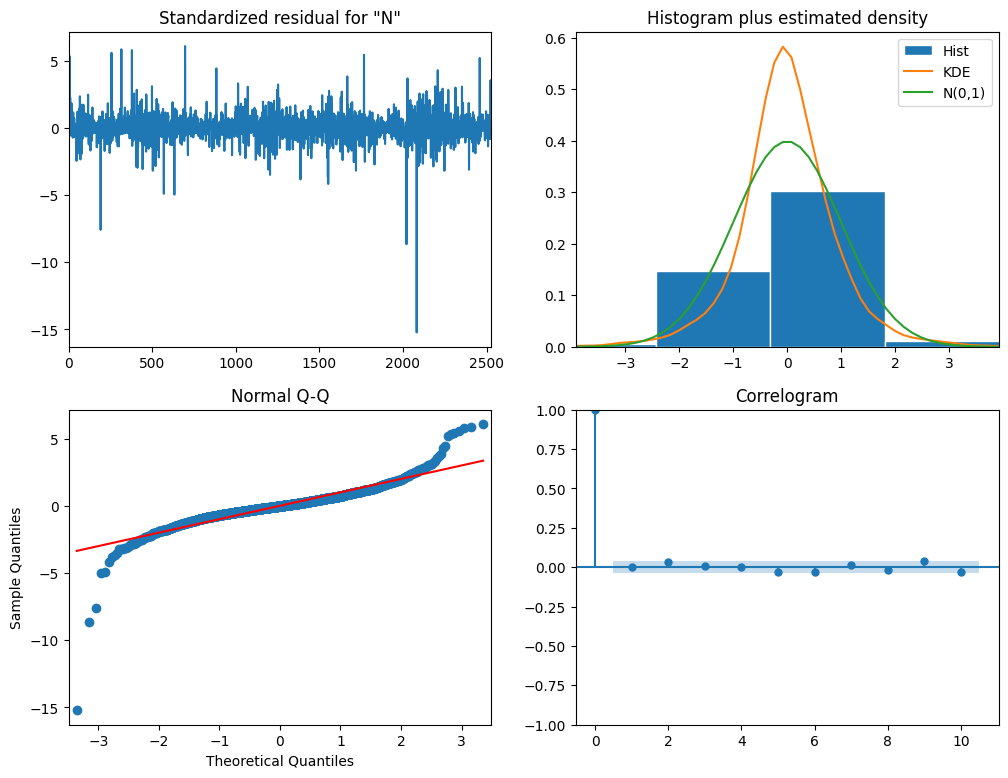

In [65]:
# Diagnostic Report for ARIMA(1,1,0) Model
mod_arima.plot_diagnostics()
plt.show()

The Normal Q-Q plot signals that the residual of the model is heavy tailed compared to a normal distribution. The correlogram chat indicates that the residual has no autocorrelation especially in the short term. Although there seems to be a bit of a statistical significance in lag 2. Using the Ljung-box test, we can check if these autocorrelation is a product of chance.

The Ljung-Box test is to test if a group of autocorrelations from model residuals are small enough to claim the residuals are independent. The test conducts  𝑛 hypothesis tests for the following  𝑛 autocorrelation groups (WorldQuant, 2023).

Each hypothesis test is constructed as follows:

Null hypothesis  𝐻0
 : all autocorrelations in the group are small enough so that residuals are independent

Alternative hypothesis  𝐻1
 : all autocorrelations in the group are not small enough so that the residuals are not independent

If the  𝑝
 -value from each hypothesis test is  >0.05
 , we cannot reject the null hypothesis. We then conclude that residuals from this model are independent

#### Figure 9: Ljung-Box Estimation

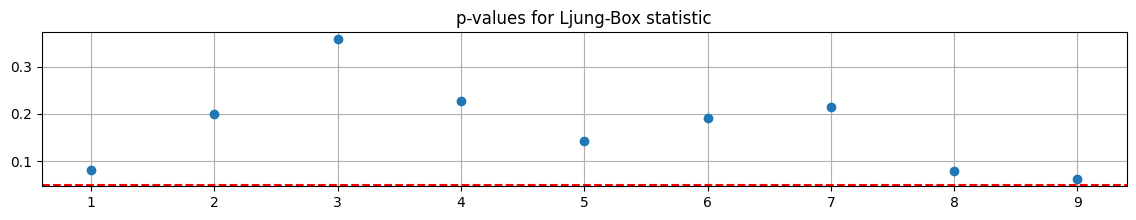

In [66]:
# Ljung-Box test for no serial correlation of standardized residuals
lb_test = mod_arima.test_serial_correlation(method="ljungbox", df_adjust=True, lags=None)

# plot Ljung-Box test p-values and 0.05 significance line
plt.figure(figsize=(14, 2))
plt.plot(lb_test[0][1], linestyle="", marker="o")
plt.axhline(y=0.05, color="red", linestyle="--")
plt.title("p-values for Ljung-Box statistic")
plt.grid()
plt.show()

From the test result of the Ljung-box test, the groups of all lags are all insignificant (> 0.05). Hence we accept the null hypothesis that all the autocorrelations in the group are small enough so that the residuals are independent.

# FORECAST OF ARIMA(0,1,0)

#### Figure 10: ARIMA(0,1,0) forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


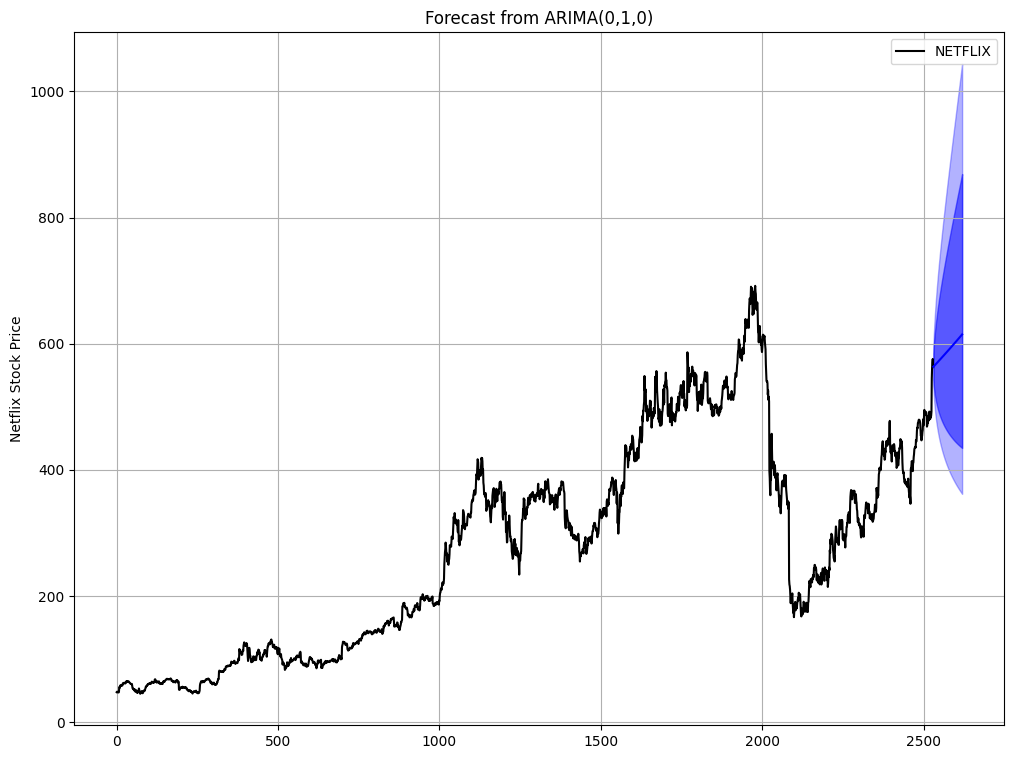

In [68]:
# Forecast Plot of ARIMA(0,1,0) with 95% Confidence Interval

# Plot NETFLIX data
nflx = data.copy()
nflx.index = [i for i in range(len(nflx))]  # Set numeric index
nflx.plot(ylabel="Netflix Stock Price", title="Forecast from ARIMA(0,1,0)", color="k")

# get forecast data for next 200 steps
forecast = mod_arima.get_forecast(steps=90)
forecast_mean = np.exp(forecast.predicted_mean)  # mean of forecast data
conf_int95 = forecast.conf_int(alpha=0.05)  # 95% confidence interval
conf_int80 = forecast.conf_int(alpha=0.2)  # 80% confidence interval

# plot mean forecast and 95% and 80% confidence intervals
plt.plot(forecast_mean, c="b")
plt.fill_between(conf_int95.index,
    np.exp(conf_int95["lower NETFLIX"]),
    np.exp(conf_int95["upper NETFLIX"]),
    color="b",
    alpha=0.3,
)
plt.fill_between(
    conf_int80.index,
    np.exp(conf_int80["lower NETFLIX"]),
    np.exp(conf_int80["upper NETFLIX"]),
    color="b",
    alpha=0.5,
)
plt.grid()
plt.show()

From figure 10, we can see that there is a 80% chance (darker blue shade) that Google's stock price will move within 430 and 850 for the next 90 days.